# Adversarial Attacks on ResNet-34 Model

This notebook demonstrates how to create adversarial examples using the Fast Gradient Sign Method (FGSM) attack against a pre-trained ResNet-34 model. We'll evaluate the model's performance on original images and then on adversarial examples to see how the attack affects classification accuracy.

In [1]:
import json
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T, datasets as dsets, models
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We prepare our dataset by defining normalization constants and transforms for loading images. We're using standard ImageNet normalization values since we'll be working with a pre-trained ResNet-34 model.

In [2]:
# Define normalization constants
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Define transforms for loading images
tfm = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=MEAN,std=STD)
])

# Path to dataset
root = "/kaggle/input/testdata"

# Load dataset and create data loader
dataset = dsets.ImageFolder(root, transform=tfm)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

## Model Loading

We load a pre-trained ResNet-34 model that was trained on ImageNet. This model will be the target of our adversarial attacks. We place it on the appropriate device (GPU if available).

In [3]:
# Load pre-trained ResNet-34 model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Class Mapping

Since our dataset might use different folder names than the ImageNet classes, we need to map between them. We'll either load an existing mapping from a JSON file or create a new one, assuming classes start from index 401.

In [4]:
# Load class mapping using the improved approach with class names
try:
    with open('folder_to_class_mapping.json', 'r') as f:
        folder_to_class = json.load(f)
        folder_to_class = {k: int(v) for k, v in folder_to_class.items()}
        print(f"Loaded mapping for {len(folder_to_class)} folders from file")
except:
    # Try to load label_list.json for class names (401-500)
    try:
        with open(os.path.join(root, 'labels_list.json'), 'r') as f:
            label_list = json.load(f)
            print(f"Loaded labels_list.json")
            
            # Create class name mapping (index 401-500 -> name)
            class_names = {}
            if isinstance(label_list, list):
                for item in label_list:
                    if isinstance(item, str) and ': ' in item:
                        idx, name = item.split(': ', 1)
                        class_names[int(idx)] = name
    except:
        print("Could not find labels_list.json, will use numeric labels only")
        class_names = {}
    
    print("Creating mapping from folder names to ImageNet classes...")
    folder_names = dataset.classes
    
    folder_to_class = {}
    for i, folder in enumerate(folder_names):
        class_idx = 401 + i
        folder_to_class[folder] = class_idx
        name = class_names.get(class_idx, f"Unknown_{class_idx}")
        print(f"Folder {i} ({folder}) -> Class {class_idx} ({name})")
    
    # Save the mapping for future use
    with open('folder_to_class_mapping.json', 'w') as f:
        json.dump(folder_to_class, f)
    
    print(f"Created mapping for {len(folder_to_class)} folders")

# Extract class-to-index mapping from dataset
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

Could not find labels_list.json, will use numeric labels only
Creating mapping from folder names to ImageNet classes...
Folder 0 (TestDataSet) -> Class 401 (Unknown_401)
Created mapping for 1 folders


## Task 1: Evaluating the Original Dataset

First, we evaluate the pre-trained ResNet-34 model on our original dataset to establish baseline performance metrics. We'll record both top-1 and top-5 accuracy.

In [5]:
print("=" * 50)
print("Task 1: Evaluating original dataset")
print("=" * 50)

# Evaluate model on original dataset
top1 = top5 = tot = 0
with torch.no_grad():
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        _, preds5 = out.topk(5, 1)
        preds5 = preds5.cpu().numpy()
        for i, lbl in enumerate(lbls):
            class_name = idx_to_class[lbl.item()]
            true_class = folder_to_class[class_name]
            p5 = preds5[i]
            top1 += (p5[0] == true_class)
            top5 += (true_class in p5)
        tot += lbls.size(0)

orig_top1_acc = top1 / tot
orig_top5_acc = top5 / tot
print(f"Original Top-1 accuracy: {orig_top1_acc:.2%}")
print(f"Original Top-5 accuracy: {orig_top5_acc:.2%}")

Task 1: Evaluating original dataset
Original Top-1 accuracy: 0.60%
Original Top-5 accuracy: 1.40%


## Task 2: Fast Gradient Sign Method (FGSM) Attack

Now we implement the FGSM attack, which creates adversarial examples by perturbing input images in the direction of the gradient of the loss with respect to the input. We'll use a small epsilon value (0.02) to ensure the perturbations are imperceptible to humans but can still fool the model.

First, we define utility functions and parameters for the attack:

In [6]:
print("\n" + "=" * 50)
print("Task 2: Implementing FGSM attack")
print("=" * 50)

# Function to denormalize images for visualization
def denormalize(tensor):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor

# Define attack budget
EPS_NORM = 0.02  # normalized-space budget

# Create tensors for normalization and bounds
eps = EPS_NORM
mean = torch.tensor(MEAN, device=device).view(1, 3, 1, 1)
std = torch.tensor(STD, device=device).view(1, 3, 1, 1)
min_norm = (0 - mean) / std  # valid lower bound
max_norm = (1 - mean) / std  # valid upper bound


Task 2: Implementing FGSM attack


### Generating Adversarial Examples

We now generate adversarial examples using the FGSM attack. For each image:
1. We calculate the gradient of the loss with respect to the input
2. We take a step in the direction of the gradient sign, scaled by epsilon
3. We ensure the resulting images are within the valid pixel range

In [7]:
# Lists to store adversarial images and labels
adv_imgs = []
adv_labels = []
original_imgs = []  # Store original images for visualization

# Generate adversarial examples using FGSM
for images, labels in loader:
    # Move data to device
    images, labels = images.to(device), labels.to(device)
    
    # Clone images and enable gradient tracking
    images_clone = images.clone().detach().requires_grad_(True)
    
    # Store original images for visualization
    original_imgs.append(images.clone().detach().cpu())
    
    # Convert dataset labels to true class indices
    true_idx_list = []
    for lbl in labels:
        class_name = idx_to_class[lbl.item()]
        true_idx_list.append(folder_to_class[class_name])
    
    true_idx = torch.tensor(true_idx_list, device=device)
    
    # Forward pass
    logits = model(images_clone)
    
    # Compute loss
    loss = F.cross_entropy(logits, true_idx)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # FGSM step (normalized-space)
    perturbation = eps * images_clone.grad.sign()
    adv = images_clone + perturbation
    
    # Project into valid pixel range
    adv = torch.max(torch.min(adv, max_norm), min_norm)
    
    # Store adversarial examples
    adv_imgs.append(adv.detach().cpu())
    adv_labels.append(labels.detach().cpu())

# Concatenate into final tensors on CPU
original_dataset_images = torch.cat(original_imgs, dim=0)
adv_dataset_images = torch.cat(adv_imgs, dim=0)
adv_dataset_labels = torch.cat(adv_labels, dim=0)

### Measuring Attack Success

We verify our adversarial examples by calculating L∞ distances between original and adversarial images. This ensures our perturbations are within our specified budget (epsilon).

In [8]:
# Function to calculate L∞ distance
def l_inf_distance(original, adversarial):
    return (original - adversarial).abs().max().item()

# Check L∞ distances
l_inf_distances = []
for i in range(len(original_dataset_images)):
    l_inf_dist = l_inf_distance(original_dataset_images[i], adv_dataset_images[i])
    l_inf_distances.append(l_inf_dist)

avg_l_inf_dist = sum(l_inf_distances) / len(l_inf_distances)
max_l_inf_dist = max(l_inf_distances)

print(f"Average L∞ distance: {avg_l_inf_dist:.4f}")
print(f"Maximum L∞ distance: {max_l_inf_dist:.4f}")
print(max_l_inf_dist)
print(f"L∞ constraint satisfied: {max_l_inf_dist <= EPS_NORM}")

Average L∞ distance: 0.0200
Maximum L∞ distance: 0.0200
0.020000100135803223
L∞ constraint satisfied: False


### Evaluating Model Performance on Adversarial Examples

Now we evaluate the model's performance on our adversarial examples. We'll compare with the original accuracy to measure the effectiveness of our attack.

In [9]:
# Create DataLoader for adversarial examples
from torch.utils.data import TensorDataset, DataLoader
adv_dataset = TensorDataset(adv_dataset_images, adv_dataset_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# Evaluate model on adversarial examples
top1 = top5 = tot = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        _, preds5 = out.topk(5, 1)
        preds5 = preds5.cpu().numpy()
        for i, lbl in enumerate(lbls):
            class_name = idx_to_class[lbl.item()]
            true_class = folder_to_class[class_name]
            p5 = preds5[i]
            top1 += (p5[0] == true_class)
            top5 += (true_class in p5)
        tot += lbls.size(0)

adv_top1_acc = top1 / tot
adv_top5_acc = top5 / tot
print(f"Adversarial Top-1 accuracy: {adv_top1_acc:.2%}")
print(f"Adversarial Top-5 accuracy: {adv_top5_acc:.2%}")
print(f"Top-1 accuracy drop: {orig_top1_acc - adv_top1_acc:.2%}")
print(f"Top-5 accuracy drop: {orig_top5_acc - adv_top5_acc:.2%}")
print(f"Relative Top-1 accuracy drop: {(orig_top1_acc - adv_top1_acc)/orig_top1_acc*100:.2f}%")
print(f"Relative Top-5 accuracy drop: {(orig_top5_acc - adv_top5_acc)/orig_top5_acc*100:.2f}%")

Adversarial Top-1 accuracy: 0.20%
Adversarial Top-5 accuracy: 0.60%
Top-1 accuracy drop: 0.40%
Top-5 accuracy drop: 0.80%
Relative Top-1 accuracy drop: 66.67%
Relative Top-5 accuracy drop: 57.14%


### Visualizing Successful Attacks

To better understand the impact of our adversarial perturbations, we'll identify and visualize successful attacks where:
1. The model correctly classified the original image
2. The model incorrectly classified the adversarial version
3. The perturbation is visually subtle (within our epsilon constraint)

In [10]:
# Find successful attacks for visualization
successful_attacks = []

# Evaluate model predictions on original and adversarial images
with torch.no_grad():
    for i in range(0, len(original_dataset_images), 32):
        batch_size = min(32, len(original_dataset_images) - i)
        orig_batch = original_dataset_images[i:i+batch_size].to(device)
        adv_batch = adv_dataset_images[i:i+batch_size].to(device)
        labels_batch = adv_dataset_labels[i:i+batch_size].to(device)
        
        # Get predictions
        orig_logits = model(orig_batch)
        adv_logits = model(adv_batch)
        
        _, orig_preds = orig_logits.max(1)
        _, adv_preds = adv_logits.max(1)
        
        # Convert dataset labels to true class indices
        true_classes = []
        for lbl in labels_batch:
            class_name = idx_to_class[lbl.item()]
            true_classes.append(folder_to_class[class_name])
        
        true_classes = torch.tensor(true_classes, device=device)
        
        # Check for successful attacks
        for j in range(batch_size):
            if orig_preds[j] == true_classes[j] and adv_preds[j] != true_classes[j]:
                successful_attacks.append({
                    'original': orig_batch[j].cpu(),
                    'adversarial': adv_batch[j].cpu(),
                    'true_class': true_classes[j].item(),
                    'orig_pred': orig_preds[j].item(),
                    'adv_pred': adv_preds[j].item(),
                    'l_inf_dist': l_inf_distance(orig_batch[j], adv_batch[j])
                })
            
            # If we have enough examples, stop
            if len(successful_attacks) >= 5:
                break
        
        if len(successful_attacks) >= 5:
            break

### Visual Comparison of Original and Adversarial Images

We display 5 successful attacks, showing:
1. The original image and its correct prediction
2. The adversarial image and its incorrect prediction
3. A magnified view of the difference between them to help see the subtle perturbations

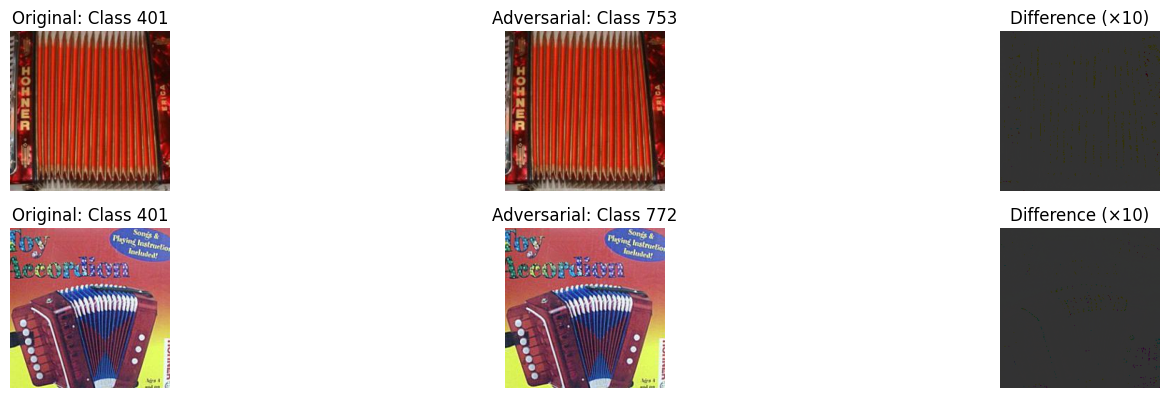

In [11]:
# Visualize successful attacks
plt.figure(figsize=(15, 10))
for i, attack in enumerate(successful_attacks[:5]):
    # Original image
    plt.subplot(5, 3, i*3 + 1)
    img = denormalize(attack['original']).permute(1, 2, 0).numpy().clip(0, 1)
    plt.imshow(img)
    plt.title(f"Original: Class {attack['true_class']}")
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(5, 3, i*3 + 2)
    img = denormalize(attack['adversarial']).permute(1, 2, 0).numpy().clip(0, 1)
    plt.imshow(img)
    plt.title(f"Adversarial: Class {attack['adv_pred']}")
    plt.axis('off')
    
    # Difference (magnified for visibility)
    plt.subplot(5, 3, i*3 + 3)
    diff = (attack['adversarial'] - attack['original']).abs()
    diff = diff.permute(1, 2, 0).numpy() * 10  # Magnify the difference
    plt.imshow(np.clip(diff, 0, 1))
    plt.title(f"Difference (×10)")
    plt.axis('off')

plt.tight_layout()
plt.savefig("fgsm_attack_examples.png")
plt.show()

### Saving Adversarial Dataset

Finally, we save our adversarial dataset along with performance metrics for future analysis or defense development. This allows us to reuse these examples without regenerating them.

In [12]:
# Save the adversarial dataset
os.makedirs("adversarial_datasets", exist_ok=True)
torch.save({
    'images': adv_dataset_images,
    'labels': adv_dataset_labels,
    'original_accuracy': {'top1': orig_top1_acc, 'top5': orig_top5_acc},
    'adversarial_accuracy': {'top1': adv_top1_acc, 'top5': adv_top5_acc}
}, "adversarial_datasets/adversarial_test_set_1.pt")

print("\nAdversarial Test Set 1 saved successfully!")


Adversarial Test Set 1 saved successfully!
